# Matching networks, *one-shot learning* on Omniglot dataset

- Learning from few examples
- Model architecture : *differentiable nearest neighbor++*
- Training strategy : one-shot learning from a support set

**Core idea: "Lets train a fully end-to-end nearest neighbor classifer!"**

- CNN helps to encode images to continuous vectors


### Dataset splitting

$$
\text{Dataset} \rightarrow \text{Train/Val} \, / \, \text{Test} \\
\text{Train/Val} \rightarrow (X, Y) + (X', Y') : Y \cap Y' = 0 \\ 
$$

No intersection between labels $Y$ and $Y'$. Dataset $(X', Y')$ is for one-shot learning.

- N-way, k shot : number of labels in $Y'$ is $N$ and for each label $y'$ from $Y'$, number of $x' \in X' : x' \leftrightarrow y'$ equals k.

### Model

The output $\hat{y}$ for a test example $\hat{x}$ is computed very similar to the Nearest Neighbors:
$$
\hat{y} = \sum_{x_i, y_i \in S} a(\hat{x}, x_i) y_i
$$
where $S$ is a supporting set sampled from training samples $X', Y'$. 

#### CNN as embedding functions


### Training 

- Sample from $X', Y'$ a supporting set $S$ and batch of $x_i$ samples $B$.
- 


The N-way Omniglot task setup is as follows: pick $N$ unseen character classes, independent of alphabet, as $L$. Provide the model with one drawing of each of the $N$ characters as $S∼L$ and a batch $B∼L$.







References:
- [Matching Networks for One Shot Learning](https://arxiv.org/pdf/1606.04080.pdf)
- [github implementation 1](https://github.com/zergylord/oneshot)
- [github implementation 2](https://github.com/AntreasAntoniou/MatchingNetworks)
- [omniglot](https://github.com/brendenlake/omniglot)
- [karpathy notes](https://github.com/karpathy/paper-notes/blob/master/matching_networks.md)

In [96]:
import os, sys
import numpy as np
import cv2

os.environ['TENSORPACK_PIPEDIR'] = "tmp_pipedir"

## Omniglot dataset

This dataset contains 1623 different handwritten characters from 50 different alphabets.
Each of the 1623 characters was drawn online via Amazon's Mechanical Turk by 20 different people.

In [3]:
if not os.path.exists("omniglot"):
    !git clone https://github.com/brendenlake/omniglot
    !cd omniglot/python/ && unzip images_background.zip        
    !cd omniglot/python/ && unzip images_background_small1.zip
    !cd omniglot/python/ && unzip images_background_small2.zip    
    !cd omniglot/python/ && unzip images_evaluation.zip

In [27]:
import matplotlib.pylab as plt
%matplotlib inline

In [107]:
!ls omniglot/python/

images_background	      images_background.zip
images_background_small1      images_evaluation
images_background_small1.zip  images_evaluation.zip
images_background_small2      one-shot-classification
images_background_small2.zip


In [108]:
TRAIN_DATA_PATH = "omniglot/python/images_background/"
train_character_groups = !ls {TRAIN_DATA_PATH}
train_character_groups = list(train_character_groups)
print(train_character_groups)

TEST_DATA_PATH = "omniglot/python/images_evaluation/"
test_character_groups = !ls {TEST_DATA_PATH}
test_character_groups = list(test_character_groups)
print(test_character_groups)

['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh']
['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG']


In [109]:
train_group_char_id_ids = {}
for g in train_character_groups:
    res = !ls {TRAIN_DATA_PATH}/{g}
    char_ids = list(res)
    train_group_char_id_ids[g] = {}
    for char_id in char_ids:
        res = !ls {TRAIN_DATA_PATH}/{g}/{char_id}
        train_group_char_id_ids[g][char_id] = [_id[:-4] for _id in list(res)]

In [87]:
test_group_char_id_ids = {}
for g in test_character_groups:
    res = !ls {TEST_DATA_PATH}/{g}
    char_ids = list(res)
    test_group_char_id_ids[g] = {}
    for char_id in char_ids:
        res = !ls {TEST_DATA_PATH}/{g}/{char_id}
        test_group_char_id_ids[g][char_id] = [_id[:-4] for _id in list(res)]

In [91]:
def get_image(group, char_id, _id, _type="Train"):    
    assert _type in ["Train", "Test"]
    path = TRAIN_DATA_PATH if _type == "Train" else TEST_DATA_PATH
    path = os.path.join(path, group, char_id, "%s.png" % _id)
    assert os.path.exists(path), "Path '%s' does not exist" % path
    img = cv2.imread(path)
    return img

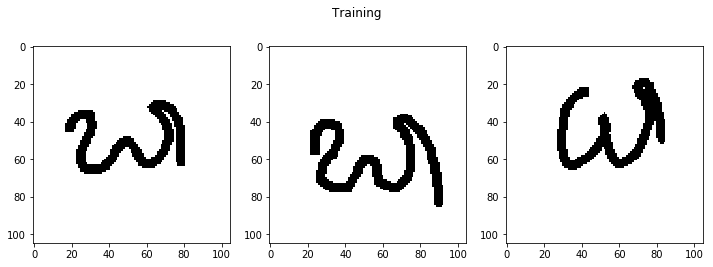

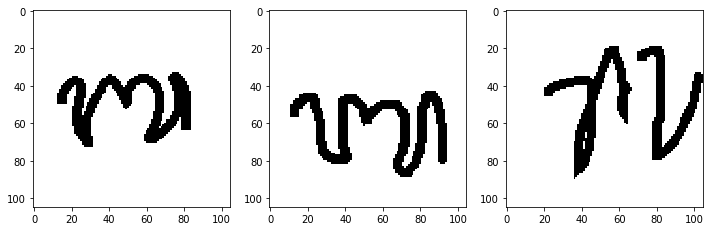

In [110]:
plt.figure(figsize=(12, 4))
plt.suptitle("Training")
plt.subplot(131)
plt.imshow(get_image('Balinese', 'character01', '0108_01'))
plt.subplot(132)
plt.imshow(get_image('Balinese', 'character01', '0108_02'))
plt.subplot(133)
plt.imshow(get_image('Balinese', 'character01', '0108_03'))

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(get_image('Balinese', 'character02', '0109_01'))
plt.subplot(132)
plt.imshow(get_image('Balinese', 'character02', '0109_02'))
plt.subplot(133)
_ = plt.imshow(get_image('Balinese', 'character02', '0109_03'))

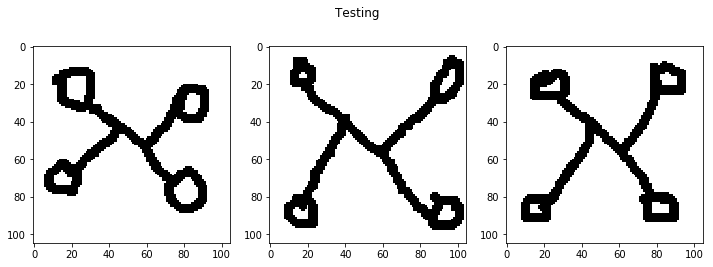

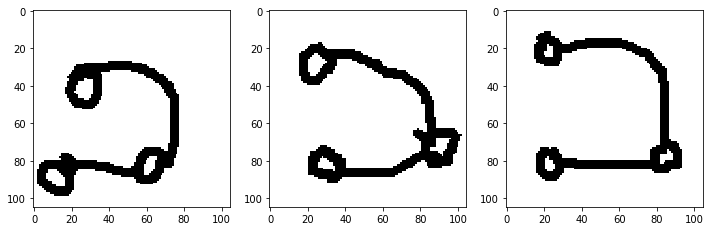

In [111]:
plt.figure(figsize=(12, 4))
plt.suptitle("Testing")
plt.subplot(131)
plt.imshow(get_image('Angelic', 'character01', '0965_01', "Test"))
plt.subplot(132)
plt.imshow(get_image('Angelic', 'character01', '0965_02', "Test"))
plt.subplot(133)
plt.imshow(get_image('Angelic', 'character01', '0965_03', "Test"))

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(get_image('Angelic', 'character02', '0966_01', "Test"))
plt.subplot(132)
plt.imshow(get_image('Angelic', 'character02', '0966_02', "Test"))
plt.subplot(133)
_ = plt.imshow(get_image('Angelic', 'character02', '0966_03', "Test"))

## Setup dataflow 
with *tensorpack*

- Training / validation datasets
- Testing dataset

### Training phase:  N-way, k shots learning task




In [113]:
from tensorpack.dataflow import RNGDataFlow
from tensorpack.utils.utils import fix_rng_seed
from tensorpack import __version__
__version__

'0.7.1'

In [114]:
seed = 12345
fix_rng_seed(seed)

In [143]:
class OmniglotDataset(RNGDataFlow):
    
    def __init__(self, dataset_type="Train", data_path="", group_char_id_ids={}, shuffle=True):
        assert dataset_type in ["Train", "Test"]
        assert len(group_char_id_ids) > 0
        self.dataset_type = dataset_type
        self.data_path = data_path
        self.group_char_id_ids = group_char_id_ids
        self.shuffle = shuffle
                
        self.data_ids = []
        for g in group_char_id_ids:            
            group_char_ids = group_char_id_ids[g]
            for char_id in group_char_ids:
                p = os.path.join(g, char_id)
                self.data_ids.extend([os.path.join(p, "%s.png" % _id) for _id in group_char_ids[char_id]])
            
    def _get_image(self, image_id):    
        path = os.path.join(self.data_path, image_id)
        assert os.path.exists(path), "Path '%s' does not exist" % path
        img = cv2.imread(path)
        return img
        
    def _get_label(self, image_id):
        # Remove .png and char id from the image_id
        return image_id[:-7]
    
    def size(self):
        return len(self.data_ids)
    
    def get_data(self):
        idxs = np.arange(len(self.data_ids))
        if self.shuffle:
            self.rng.shuffle(idxs)
        for k in idxs:
            yield self._get_image(self.data_ids[k]), self._get_label(self.data_ids[k])    

In [157]:
trainval_ds = OmniglotDataset("Train", data_path=TRAIN_DATA_PATH, group_char_id_ids=train_group_char_id_ids)
trainval_ds.reset_state()

test_ds = OmniglotDataset("Test", data_path=TEST_DATA_PATH, group_char_id_ids=test_group_char_id_ids)
test_ds.reset_state()

# print(train_ds.size(), test_ds.size())

Split training dataset on train/val sets

In [158]:
from tensorpack.dataflow import ProxyDataFlow
from sklearn.model_selection import KFold


class KFoldsDataset(ProxyDataFlow):
    """
    Extract k-fold train/val datasets
    """
    def __init__(self, ds, data_type, fold_index, n_folds):
        """
        Args:
            ds (DataFlow): input DataFlow
            data_type: train or val
            fold_index: fold index
            n_folds: number of folds for K-Folds train/val dataset extraction
        """
        assert fold_index >= 0 or fold_index < n_folds
        assert data_type in ['train', 'val']
        super(KFoldsDataset, self).__init__(ds)        
        
        kfs = KFold(n_splits=n_folds)
        index = 0
        for train_indices, val_indices in kfs.split(range(ds.size())):
            if index != fold_index:
                index += 1
                continue
            self.indices = train_indices if data_type == 'train' else val_indices
            break

    def size(self):
        return len(self.indices)
            
    def get_data(self):
        index = 0
        for dp in self.ds.get_data():            
            if index in self.indices:
                yield dp
            index += 1

In [159]:
train_ds = KFoldsDataset(trainval_ds, 'train', 0, 7)
val_ds = KFoldsDataset(trainval_ds, 'val', 0, 7)

Sample from 

In [155]:
# plt.figure(figsize=(12, 4))

# img, label = next(train_ds.get_data())
# plt.subplot(121)
# plt.title("Train - %s" % label)
# plt.imshow(img)

# img, label = next(test_ds.get_data())
# plt.subplot(122)
# plt.title("Test - %s" % label)
# _ = plt.imshow(img)